In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math as mth
from collections import Counter

In [ ]:
import numpy as np
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import r2_score

In [115]:
def get_n_variables(X_set, y_set, n_vars=5):

    alphas = np.logspace(-4, 0, 100)
    y = y_set.values.ravel()

    best_diff = np.inf
    best_coef = None

    for a in alphas:

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", Lasso(alpha=a, max_iter=10000))
        ])

        pipe.fit(X_set.values, y)

        coef = pipe.named_steps["model"].coef_
        n_nonzero = np.sum(coef != 0)

        diff = abs(n_nonzero - n_vars)

        if n_nonzero == n_vars:
            selected = coef != 0
            coef_series = pd.Series(coef[selected],
                                    index=X_set.columns[selected])
            return pd.DataFrame(coef_series, columns=["beta"])

        if diff < best_diff:
            best_diff = diff
            best_coef = coef

    selected = best_coef != 0
    coef_series = pd.Series(best_coef[selected],
                            index=X_set.columns[selected])

    return pd.DataFrame(coef_series, columns=["beta"])

In [116]:
def r2_lasso_ols(y_variable, df_Y, df_X):
    df_test = pd.merge(df_Y [[y_variable]], 
                   df_X, 
                   how = "inner", 
                   left_index= True, 
                   right_index= True)

    x_variable = [x for x in df_test.columns if x not in [y_variable]]

    y_train = df_test[[y_variable]]
    X_train = df_test[x_variable]

    df_5_betas = get_n_variables(X_train, y_train)

    col_5betas = df_5_betas.index
    X_train_ols = df_test[col_5betas].to_numpy()

    ols = LinearRegression()
    ols.fit(X_train_ols, y_train)

    r2 = ols.score(X_train_ols, y_train)

    return r2, df_5_betas
    

In [156]:
def get_min_elements_for_r2(X_set, y_set, target_r2):
    
    alphas = np.logspace(-4, 0, 100)
    y = y_set.values.ravel()
    
    best_n = np.inf
    best_alpha = None
    best_r2 = None
    
    for a in alphas:
        
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", Lasso(alpha=a, max_iter=10000))
        ])
        
        pipe.fit(X_set.values, y)
        
        y_hat = pipe.predict(X_set.values)
        r2 = r2_score(y, y_hat)
        
        coef = pipe.named_steps["model"].coef_
        n_nonzero = np.sum(coef != 0)
        
        # si alcanza el R2 objetivo
        if r2 >= target_r2:
            if n_nonzero < best_n:
                best_n = n_nonzero
                best_alpha = a
                best_r2 = r2
    
    return {
        "min_elements": best_n,
        "alpha": best_alpha,
        "achieved_r2": best_r2
    }

# Homework 3

## Exercise 1

1. Download the `topics.csv` file from Canvas. This file contains labeled attention to topics from [structureofnews.com](https://structureofnews.com). Additionally, download the `macro.csv` file from Canvas. This file contains a series of financial and macroeconomic outcome variables.


In [6]:
path_topics = "../Source/topics.csv"
df_topics = pd.read_csv(path_topics)
df_topics["date"] = pd.to_datetime(df_topics["date"], format = "%Y-%m-%d")
df_topics.set_index("date", inplace = True)
display(df_topics.head())

,Natural disasters,Internet,Soft drinks,Mobile devices,Profits,M&A,Changes,Police/crime,Research,Executive pay,...,European politics,Size,NASD,Mexico,Retail,Long/short term,Wide range,Lawsuits,UK,Revenue growth
date,,,,,,,,,,,,,,,,,,,,,
1984-01-01,0.003393,0.001054,0.003522,0.001552,0.009622,0.004586,0.003639,0.004703,0.004628,0.003310,...,0.009105,0.003894,0.003490,0.004669,0.005357,0.004293,0.004955,0.008534,0.004675,0.002961
1984-02-01,0.004640,0.000975,0.004115,0.001611,0.008956,0.005205,0.003648,0.004393,0.004115,0.003534,...,0.007414,0.004008,0.004439,0.003033,0.004055,0.004467,0.004519,0.008337,0.004582,0.003218
1984-03-01,0.005294,0.001018,0.003355,0.001546,0.005529,0.006112,0.003461,0.004456,0.004211,0.003181,...,0.008363,0.003832,0.004134,0.003516,0.004393,0.003914,0.004839,0.009045,0.004731,0.003135
1984-04-01,0.004181,0.000927,0.003663,0.001612,0.010934,0.004572,0.003014,0.005091,0.003741,0.004565,...,0.006124,0.003205,0.003686,0.003467,0.005167,0.004159,0.004557,0.008473,0.003942,0.003276
1984-05-01,0.004179,0.001012,0.003105,0.001612,0.005622,0.004704,0.002953,0.005669,0.003715,0.004073,...,0.007005,0.003816,0.005254,0.003947,0.005518,0.004400,0.005332,0.010317,0.004083,0.003211


In [7]:
path_macro = "../Source/macro.csv"
df_macro = pd.read_csv(path_macro)
df_macro["date"] = pd.to_datetime(df_macro["date"], format = "%Y-%m-%d")
df_macro.set_index("date", inplace = True)
display(df_macro.head())


,vol,mret,indpro,indprol1,Agric_vol,Food_vol,Soda_vol,Beer_vol,Smoke_vol,Toys_vol,...,Boxes_vol,Trans_vol,Whlsl_vol,Rtail_vol,Meals_vol,Banks_vol,Insur_vol,RlEst_vol,Fin_vol,Other_vol
date,,,,,,,,,,,,,,,,,,,,,
1984-01-01,-2.441528,-0.013821,0.019598,0.004659,0.310845,0.095329,-0.032064,-0.026693,-1.039950,0.054518,...,-0.501197,0.086025,0.474194,0.560788,-0.656638,-0.158339,0.446504,-0.183200,-0.247725,-0.538995
1984-02-01,-2.215468,-0.038863,0.004659,0.004671,-0.081430,-0.002799,-0.307625,-0.003307,-0.517003,0.273818,...,-0.505793,0.386029,0.502140,0.360408,-0.676141,-0.006122,0.018590,-0.240550,-0.262150,-0.473532
1984-03-01,-2.088957,0.013777,0.004671,0.005914,-0.338281,-0.450892,-0.634702,0.225436,-0.398322,0.042761,...,-0.241823,0.025585,0.429562,0.163409,-0.659300,0.090492,-0.014528,-0.242914,-0.317061,-0.810635
1984-04-01,-2.202551,0.002938,0.005914,0.005345,0.317874,-0.537147,-1.227010,0.053647,-0.364971,-0.210269,...,-0.079248,0.376537,0.377819,0.010248,-0.743154,-0.064234,0.475832,-0.099469,-0.241596,-0.644135
1984-05-01,-2.295892,-0.053505,0.005345,0.003558,0.358976,-0.254617,-0.697659,0.054901,0.415290,-0.004416,...,-0.230033,0.311959,0.430125,-0.465393,-0.679861,-0.063304,0.497335,-0.081488,-0.206172,-0.555334


(a) Using the `mret` (for market return) column from the `macro.csv` file, fit LASSO for a range of penalty parameters to the topics data. Select the penalty that yields five non-zero coefficients. Then run OLS with these five topics. What is the $R^2$? Interpret the topics selected.

In [129]:
r2_exercise1, df_betas = r2_lasso_ols("mret", 
                            df_macro[["mret"]], 
                            df_topics)
print(f"R2: {round(r2_exercise1 * 100, 2)}%")

R2: 10.79%


Our regression yields an $R^{2}$ of 10.8%, indicating that the selected topics explain a meaningful portion of the variation in market returns. The five topics selected by LASSO are:

* Problems
* Recession
* Bear/Bull Market
* Federal Reserve
* Options/VIX

These topics are closely related to macroeconomic risk, monetary policy, and market sentiment. Their selection suggests that periods of heightened attention to economic distress, market regimes, central bank actions, and volatility are strongly associated with market movements. In other words, shifts in news attention toward these themes help explain fluctuations in aggregate market returns.


(b) Repeat this procedure for `vol`, `indpro`, `indprol1` (industrial production growth one period in the future), and each of the `indvol` columns. Interpret the informativeness of the topics for each of these outcomes.

In [13]:
df_columns = pd.DataFrame(df_macro.columns.to_list(), columns = ["name"])
vol_columns = df_columns[df_columns["name"].str.contains("vol")]["name"]
list_variables = ["indpro", "indprol1"] + vol_columns.to_list()

In [ ]:
list_final_information = []
cont = 0
for y_variable in list_variables:
    
    r2_exercise, df_betas = r2_lasso_ols(y_variable, 
                            df_macro[[y_variable]], 
                            df_topics)
    
    list_final_information.append([y_variable, r2_exercise, df_betas.index])
    #print(cont * 100 /len(list_variables))
    cont +=1 

0.0
1.9230769230769231
3.8461538461538463
5.769230769230769
7.6923076923076925
9.615384615384615
11.538461538461538
13.461538461538462
15.384615384615385
17.307692307692307
19.23076923076923
21.153846153846153
23.076923076923077
25.0
26.923076923076923
28.846153846153847
30.76923076923077
32.69230769230769
34.61538461538461
36.53846153846154
38.46153846153846
40.38461538461539
42.30769230769231
44.23076923076923
46.15384615384615
48.07692307692308
50.0
51.92307692307692
53.84615384615385
55.76923076923077
57.69230769230769
59.61538461538461
61.53846153846154
63.46153846153846
65.38461538461539
67.3076923076923
69.23076923076923
71.15384615384616
73.07692307692308
75.0
76.92307692307692
78.84615384615384
80.76923076923077
82.6923076923077
84.61538461538461
86.53846153846153
88.46153846153847
90.38461538461539
92.3076923076923
94.23076923076923
96.15384615384616
98.07692307692308


In [163]:
df_info_variables = pd.DataFrame(list_final_information, columns = ["variable", "r_squared", "topics"])
df_info_variables = pd.concat([df_info_variables, pd.DataFrame(["mret", 
                                                                r2_exercise1, 
                                                                df_betas.index], 
                                                               index = ["variable", 
                                                                        "r_squared", 
                                                                        "topics"]).transpose()])
df_info_variables.reset_index(drop = True, inplace = True)
df_info_variables["topics"] = df_info_variables["topics"].apply(lambda x: x.to_list())
df_info_variables["n_topics"] = df_info_variables["topics"].apply(lambda x: len(x))
df_5_variables = df_info_variables[df_info_variables["n_topics"] == 5]
df_not5_variables = df_info_variables[df_info_variables["n_topics"] != 5]

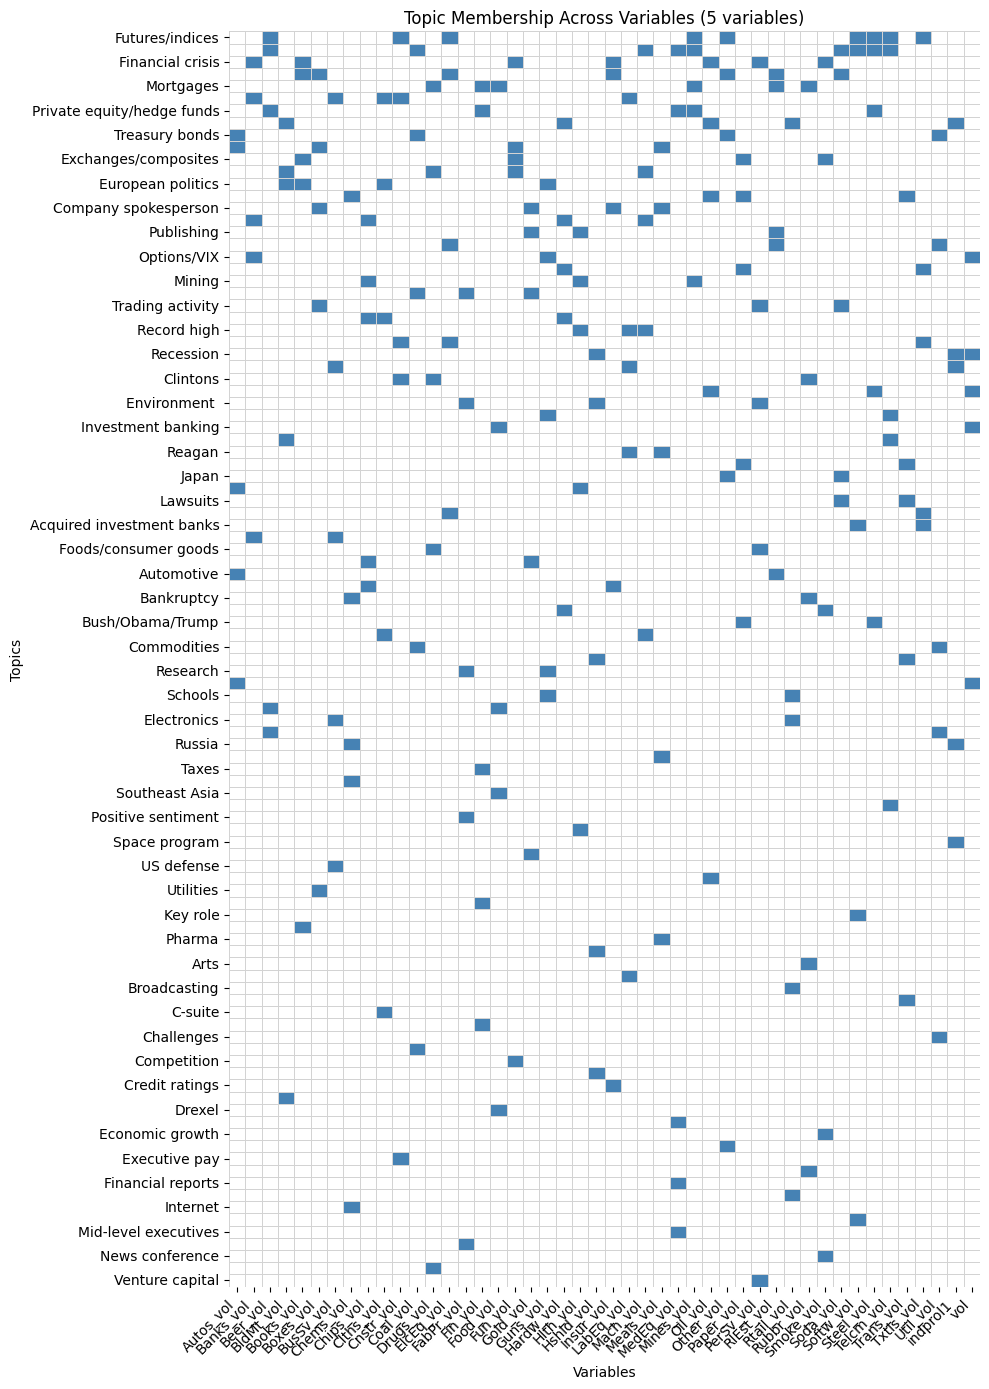

In [39]:
df = df_5_variables.copy()
df["topics"] = df["topics"].apply(lambda x: x if isinstance(x, list) else eval(x))

df_exploded = df.explode("topics")

heatmap_df = (
    df_exploded
    .assign(value=1)
    .pivot_table(
        index="topics",
        columns="variable",
        values="value",
        fill_value=0
    )
)

heatmap_df = heatmap_df.loc[
    heatmap_df.sum(axis=1).sort_values(ascending=False).index
]

plt.figure(figsize=(10, 14))
sns.heatmap(
    heatmap_df,
    cmap=["white", "steelblue"],
    cbar=False,
    linewidths=0.5,
    linecolor="lightgray"
)

plt.title("Topic Membership Across Variables (5 variables)")
plt.xlabel("Variables")
plt.ylabel("Topics")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

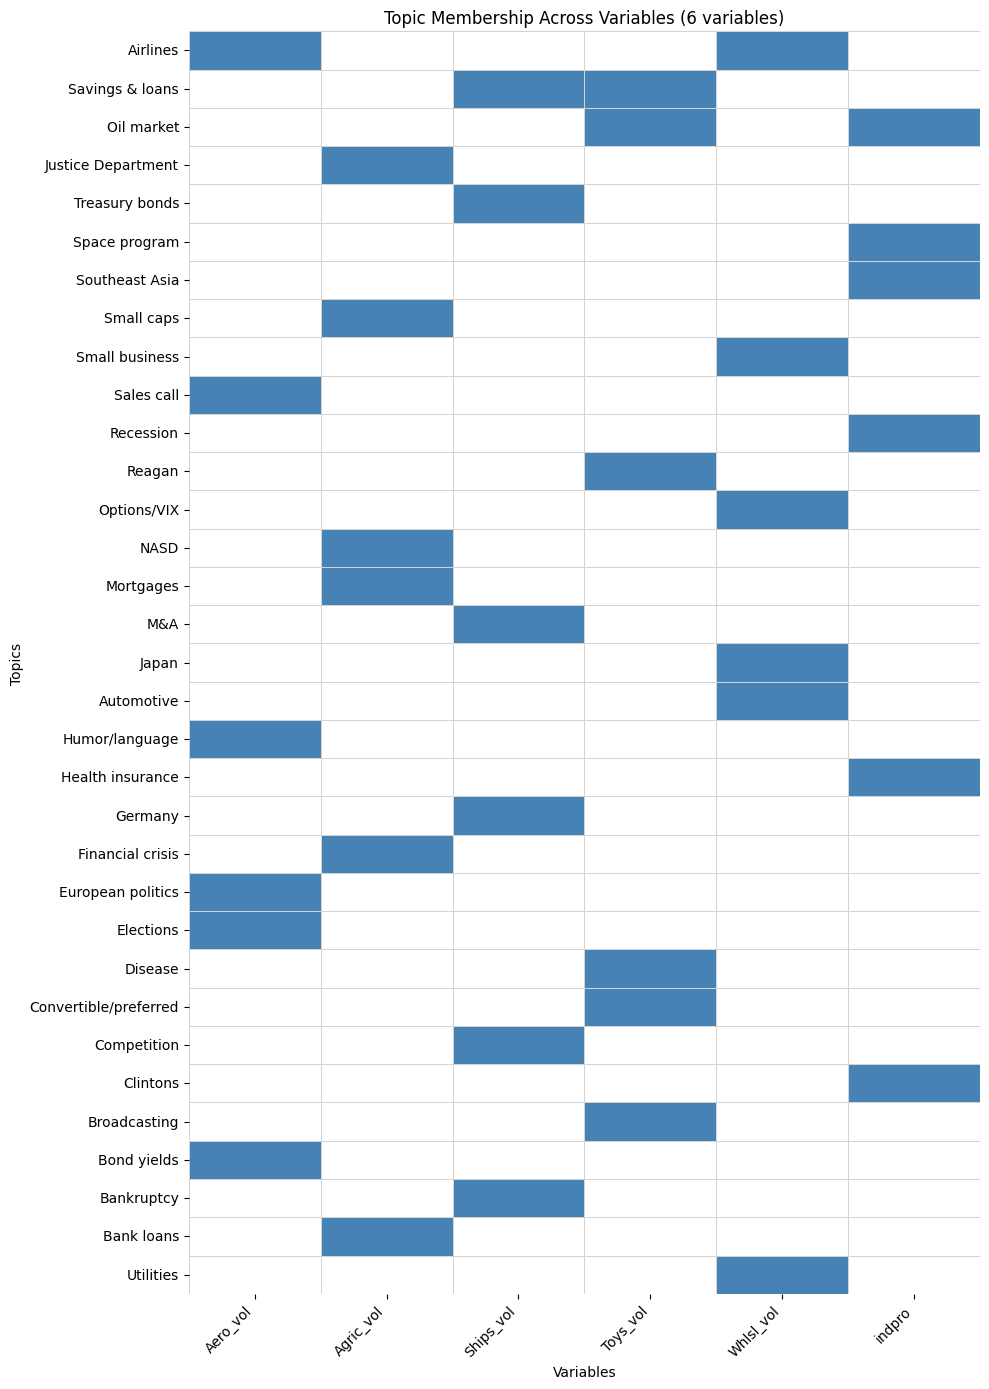

In [40]:
df = df_not5_variables.copy()
df["topics"] = df["topics"].apply(lambda x: x if isinstance(x, list) else eval(x))

df_exploded = df.explode("topics")

heatmap_df = (
    df_exploded
    .assign(value=1)
    .pivot_table(
        index="topics",
        columns="variable",
        values="value",
        fill_value=0
    )
)

heatmap_df = heatmap_df.loc[
    heatmap_df.sum(axis=1).sort_values(ascending=False).index
]

plt.figure(figsize=(10, 14))
sns.heatmap(
    heatmap_df,
    cmap=["white", "steelblue"],
    cbar=False,
    linewidths=0.5,
    linecolor="lightgray"
)

plt.title("Topic Membership Across Variables (6 variables)")
plt.xlabel("Variables")
plt.ylabel("Topics")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

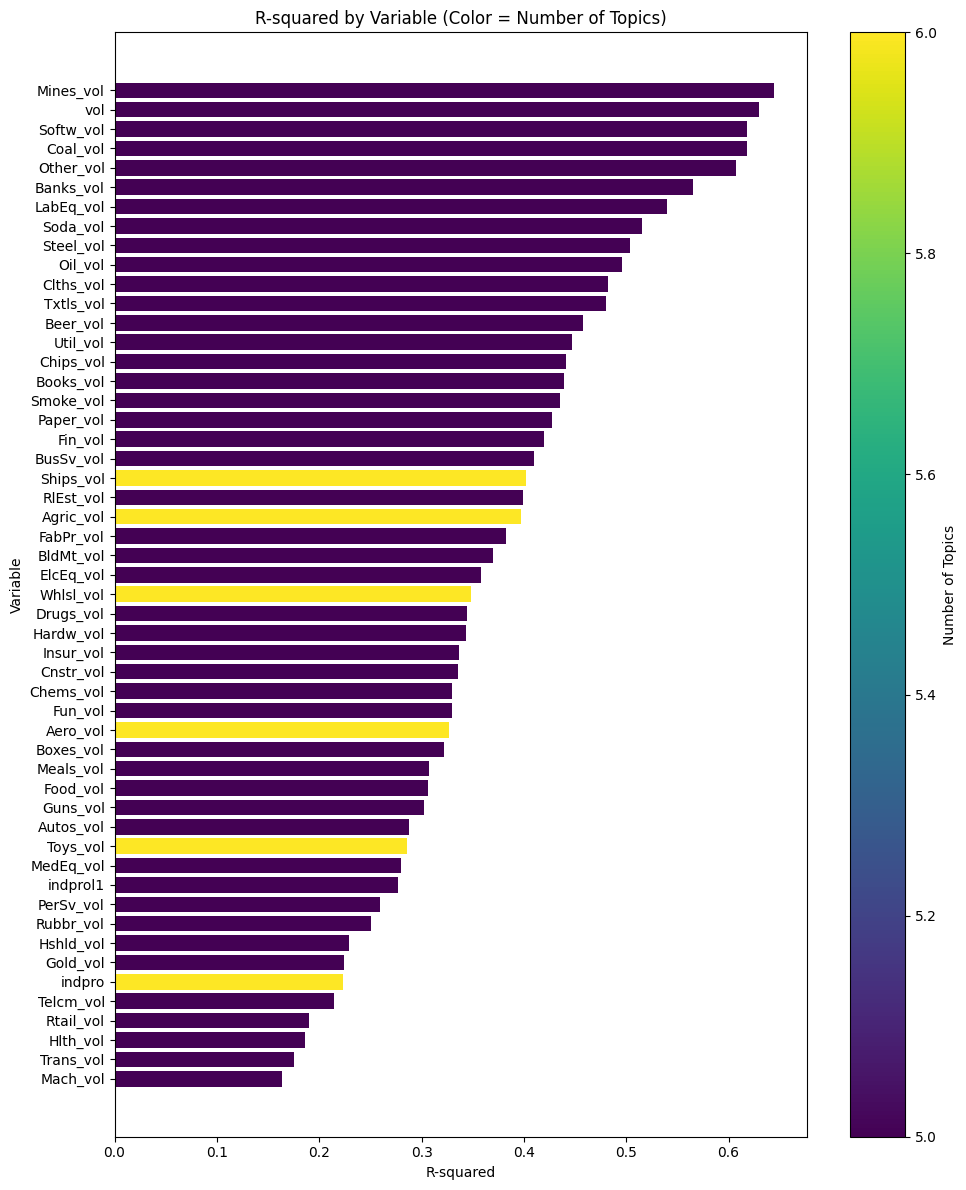

In [45]:
df = df_info_variables.copy()
df = df.sort_values("r_squared", ascending=True)

fig, ax = plt.subplots(figsize=(10, 12))

norm = plt.Normalize(df["n_topics"].min(), df["n_topics"].max())
colors = plt.cm.viridis(norm(df["n_topics"]))

bars = ax.barh(
    df["variable"],
    df["r_squared"],
    color=colors
)

ax.set_xlabel("R-squared")
ax.set_ylabel("Variable")
ax.set_title("R-squared by Variable (Color = Number of Topics)")

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Number of Topics")

plt.tight_layout()
plt.show()

(c) Using what you learned in the first problem set, let’s now try our best to forecast industrial
production growth in real time. Provide some reasoning for your modeling decisions.

In [200]:
##Calculaing R2 in the sample for PCA regression
df_test = pd.merge(
    df_macro[["indprol1"]],
    df_topics,
    how="inner",
    left_index=True,
    right_index=True
).dropna()

y = df_test["indprol1"].values.ravel()
X = df_test.drop(columns=["indprol1"])

pcr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("ols", LinearRegression())
])

max_k = min(50, X.shape[1])
param_grid = {"pca__n_components": list(range(1, max_k + 1))}

cv = GridSearchCV(
    pcr,
    param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1
)

cv.fit(X, y)

best_model = cv.best_estimator_
best_k = cv.best_params_["pca__n_components"]
r2_is = best_model.score(X, y)


In [201]:
#Comparing data
df_in_the_sample = pd.DataFrame({"PCA-OLS": [r2_is],
                                 "Lasso-OLS": [df_info_variables[df_info_variables["variable"] == "indprol1"]["r_squared"].item()]}, 
                                 index = ["R2 Full Sample"])

In [202]:
#Fitting Out Of the Sample Models
# Splitting data at 2010
df_test = pd.merge(
    df_macro[["indprol1"]],
    df_topics,
    how="inner",
    left_index=True,
    right_index=True
).dropna()

train = df_test[df_test.index < "2011-01-01"]
test  = df_test[df_test.index >= "2011-01-01"]

y_train = train["indprol1"].values
X_train = train.drop(columns=["indprol1"]).values

y_test = test["indprol1"].values
X_test = test.drop(columns=["indprol1"]).values

In [203]:
##OOS with PCA regression
k = 12  

pcr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=k)),
    ("ols", LinearRegression())
])

# Fit on train only
pcr.fit(X_train, y_train)

r2_in_PCA  = pcr.score(X_train, y_train)
r2_oos_PCA = pcr.score(X_test, y_test)

In [204]:
alphas = np.logspace(-4, 0, 400)

selected_idx = None
selected_vars = None

for a in alphas:
    
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=a, max_iter=10000))
    ])
    
    pipe.fit(X_train, y_train)
    coef = pipe.named_steps["lasso"].coef_
    
    if np.sum(coef != 0) == 6:
        selected_idx = np.where(coef != 0)[0]
        selected_vars = train.drop(columns=["indprol1"]).columns[selected_idx]
        break

if selected_vars is None:
    raise ValueError("No alpha produced exactly 5 non-zero coefficients.")

print("Selected topics:")
print(list(selected_vars))

X_train_ols = X_train[:, selected_idx]
X_test_ols  = X_test[:, selected_idx]

ols = LinearRegression()
ols.fit(X_train_ols, y_train)

r2_in_Lasso  = ols.score(X_train_ols, y_train)
r2_oos_Lasso = ols.score(X_test_ols, y_test)

Selected topics:
['Russia', 'Health insurance', 'Recession', 'Agriculture', 'Watchdogs', 'Oil market']


In [205]:
#Comparing data
df_out_the_sample = pd.DataFrame({"PCA-OLS": [r2_in_PCA, r2_oos_PCA],
                                 "Lasso-OLS": [r2_in_Lasso, r2_oos_Lasso]}, 
                                 index = ["R2 In-Sample", "R2 Out-Sample"])

In [206]:
df_general_sample = pd.concat([df_in_the_sample, df_out_the_sample], axis = 0)
display(df_general_sample.style.format("{:.2%}"))

,PCA-OLS,Lasso-OLS
R2 Full Sample,14.31%,27.67%
R2 In-Sample,21.18%,30.19%
R2 Out-Sample,-72.12%,-6.62%


The Lasso-OLS model performs better than the PCA-OLS model in both the full sample and the in-sample results. In the full sample, Lasso-OLS achieves an $R^{2}$ of 27.7%, while PCA-OLS reaches 14.31%. Similarly, in-sample $R^{2}$ is higher for Lasso-OLS (30.2%) compared to PCA-OLS (21.18%).

However, both models show negative $R^{2}$ values out-of-sample. This means that neither model performs well when predicting data after 2010. Although Lasso-OLS has a smaller negative $R^{2}$ (−6.62%) than PCA-OLS (−72.12%), the results suggest that both models have weak predictive power outside the training period.

In conclusion, Lasso-OLS fits the training data better, but neither model provides strong out-of-sample predictions.

__(d) Next, download the `articles.pq` file from Canvas. This file contains headlines from the *Wall Street Journal*. Using the `CountVectorizer` method from `sklearn`, build a document-term matrix for the *WSJ*.__

In [135]:
path_articles =  "../Source/articles.pq"
df_articles = pd.read_parquet(path_articles)
df_articles["display_date"] = pd.to_datetime(df_articles["display_date"])
df_articles.head()

,accession_number,display_date,headline
0,19840102000129,1984-01-02 07:00:00,Portfolio Managers See Overseas Stocks Climbin...
1,19840117000049,1984-01-17 07:00:00,Four Big Banks Had Profit Gains In 4th Period ...
2,19840117000136,1984-01-17 07:00:00,World Brief: U.S. and Common Market Sign Accor...
3,19840117000164,1984-01-17 07:00:00,Speaking of Business: Consumers May Be Becomin...
4,19840123000136,1984-01-23 07:00:00,Dollar Moves Up On Rise in GNP; Gold Weakens -...


In [ ]:
vectorizer = CountVectorizer(
    stop_words="english",
    min_df=5,          
    max_df=0.95        
)

list_of_headlines = df_articles["headline"].to_list()
X_vectorizer = vectorizer.fit_transform(list_of_headlines)

vocab = vectorizer.get_feature_names_out()

4822

In [137]:
df_counts_articles = pd.DataFrame.sparse.from_spmatrix(
    X_vectorizer,
    index=df_articles.index,
    columns=vocab
)

#CReate a montlhy key
df_articles = df_articles.copy()
df_articles["month"] = df_articles["display_date"].dt.to_period("M").dt.to_timestamp()

df_counts_articles["month"] = df_articles["month"].values
df_counts_monthly = df_counts_articles.groupby("month").sum()

In [143]:
print(df_counts_monthly.shape)
print(len(vocab))

(408, 4821)
4822


__**(e)** Next, repeat the contemporaneous exercises from part (a) and (b) using the counts. How many non-zero counts do you need to recover the same $R^2$? What does that say about the informativeness of the counts vs. topics?__

In [ ]:
list_variables_vec = ["mret", "indpro", "indprol1"] + vol_columns.to_list()
df_variables_aux = df_info_variables.set_index("variable")

list_final_information_vec = []
cont = 0
for y_variable in list_variables_vec:

    df_reg = pd.merge(
        df_macro[[y_variable]],
        df_counts_monthly,
        how="inner",
        left_index=True,
        right_index=True
    ).dropna()
    
    y = df_reg[[y_variable]]
    X = df_reg.drop(columns=[y_variable])
    
    demo = get_min_elements_for_r2(X, y, df_variables_aux.loc[y_variable]["r_squared"])
    list_final_information_vec.append([y_variable, demo["min_elements"], demo["alpha"], demo["achieved_r2"]])

df_vect_info = pd.DataFrame(list_final_information_vec, columns = ["variable", "min_elements", "alpha", "rsquared"])
df_vect_info.rename(columns = {"r_squared":"r_squared_vect"}, inplace=True)

In [189]:
df_comparing_rsquared = pd.merge(df_vect_info, 
                                 df_info_variables[["variable", "r_squared"]], 
                                 how = "left", on = "variable")
df_comparing_rsquared.set_index("variable", inplace = True)

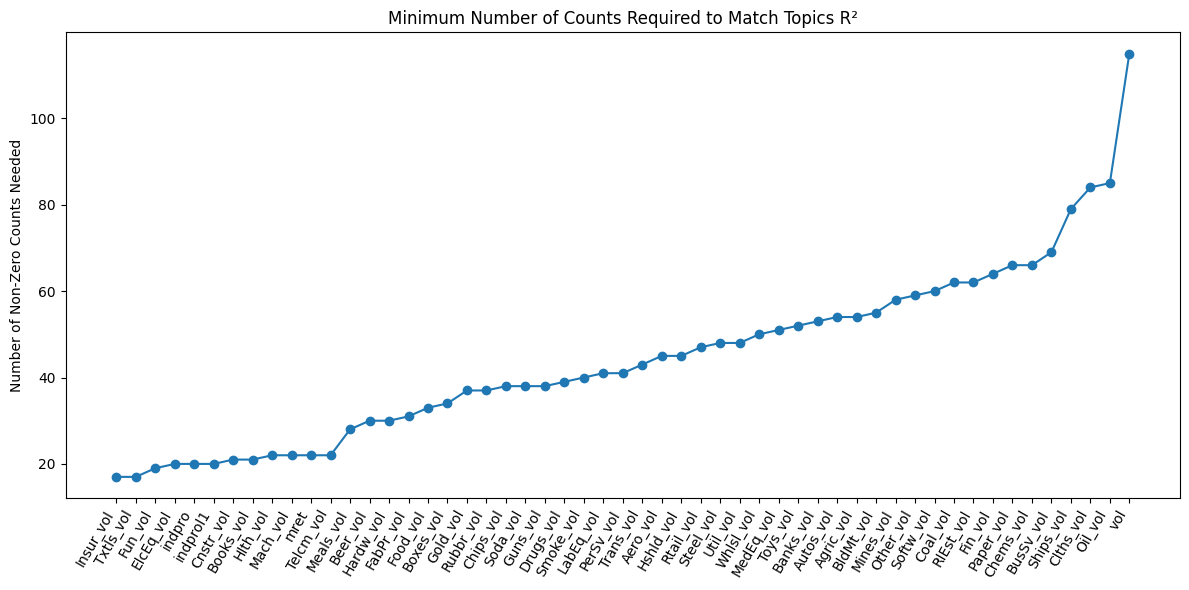

In [190]:
df_plot = df_comparing_rsquared.sort_values("min_elements")

plt.figure(figsize=(12,6))

plt.plot(
    df_plot.index,
    df_plot["min_elements"],
    marker="o"
)

plt.xticks(rotation=60, ha="right")
plt.ylabel("Number of Non-Zero Counts Needed")
plt.title("Minimum Number of Counts Required to Match Topics R²")

plt.tight_layout()
plt.show()

To match the $R^2$ obtained using five topics, we require between roughly 20 and 115 individual word counts, depending on the dependent variable. This indicates that topics provide a far more parsimonious representation of the textual information. While word counts do contain predictive information, it is dispersed across many individual terms. Topics efficiently summarize this information into a small number of latent factors, leading to similar explanatory power with substantially fewer variables.

__(f) Using the counts attempt to form the best forecasting model for industrial production
growth. How well can you do relative to the topics?__

In [222]:
#Fitting Out Of the Sample Models
# Splitting data at 2010
my_variable = "indprol1"

df_test = pd.merge(
    df_macro[[my_variable]],
    df_counts_monthly,
    how="inner",
    left_index=True,
    right_index=True
).dropna()

train = df_test[df_test.index < "2011-01-01"]
test  = df_test[df_test.index >= "2011-01-01"]

y_train = train[my_variable].values
X_train = train.drop(columns=[my_variable]).values

y_test = test[my_variable].values
X_test = test.drop(columns=[my_variable]).values

In [223]:
##OOS with PCA regression
k = 12  

pcr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=k)),
    ("ols", LinearRegression())
])

# Fit on train only
pcr.fit(X_train, y_train)

r2_in_PCA  = pcr.score(X_train, y_train)
r2_oos_PCA = pcr.score(X_test, y_test)

In [224]:
alphas = np.logspace(-4, 0, 400)

selected_idx = None
selected_vars = None

for a in alphas:
    
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=a, max_iter=10000))
    ])
    
    pipe.fit(X_train, y_train)
    coef = pipe.named_steps["lasso"].coef_
    
    if np.sum(coef != 0) == 6:
        selected_idx = np.where(coef != 0)[0]
        selected_vars = train.drop(columns=[my_variable]).columns[selected_idx]
        break

if selected_vars is None:
    raise ValueError("No alpha produced exactly 5 non-zero coefficients.")

print("Selected topics:")
print(list(selected_vars))

X_train_ols = X_train[:, selected_idx]
X_test_ols  = X_test[:, selected_idx]

ols = LinearRegression()
ols.fit(X_train_ols, y_train)

r2_in_Lasso  = ols.score(X_train_ols, y_train)
r2_oos_Lasso = ols.score(X_test_ols, y_test)

Selected topics:
['aaron', 'city', 'insights', 'spacex', 'tennille', 'williamson']


In [227]:
df_results = pd.DataFrame({"Lasso OLS":[r2_in_Lasso, r2_oos_Lasso],
              "PCA OLS": [r2_in_PCA, r2_oos_PCA]}, index= ["In the sample", "Out of the sample"])

display(df_results.style.format("{:.2%}"))

,Lasso OLS,PCA OLS
In the sample,35.23%,10.67%
Out of the sample,-107.18%,-4.44%


Although the Post-Lasso OLS model achieves a very high in-sample $R^{2}$ (35%), its out-of-sample performance is extremely poor, with an $R^{2}$ of -107%, indicating severe overfitting. In contrast, the PCA-based model is much more stable, achieving a modest in-sample fit and only slightly negative out-of-sample performance. This suggests that raw word counts are highly noisy and unstable for forecasting industrial production growth. Dimensionality reduction methods provide substantially more robust predictive performance.

__(g) Convert the raw counts into tf-idf and repeat the exercises from part (e) and (d). Summarize the differences between the tf-idf and raw count approaches. Which terms are most important in either approach?__

In [ ]:
#Repeating exercise (d)
vectorizer_idf = TfidfVectorizer(stop_words="english", min_df=5, max_df=0.95)

X_tfidf = vectorizer_idf.fit_transform(list_of_headlines)
vocab_tfidf = vectorizer_idf.get_feature_names_out()

df_tfidf_articles = pd.DataFrame.sparse.from_spmatrix(
    X_tfidf, index=df_articles.index, columns=vocab_tfidf
)

In [235]:
df_articles = df_articles.copy()
df_articles["month"] = df_articles["display_date"].dt.to_period("M").dt.to_timestamp()

df_tfidf_articles["month"] = df_articles["month"].values

df_tfidf_monthly = df_tfidf_articles.groupby("month").mean()

In [236]:
print(df_tfidf_monthly.shape)
print(len(vocab_tfidf))

(408, 4821)
4822


In [ ]:
#Repeating exercise (e)
list_variables_vec = ["mret", "indpro", "indprol1"] + vol_columns.to_list()
df_variables_aux = df_info_variables.set_index("variable")

list_final_information_vec = []
cont = 0
for y_variable in list_variables_vec:

    df_reg = pd.merge(
        df_macro[[y_variable]],
        df_tfidf_monthly,
        how="inner",
        left_index=True,
        right_index=True
    ).dropna()
    
    y = df_reg[[y_variable]]
    X = df_reg.drop(columns=[y_variable])

    print(cont * 100 / len(list_variables_vec))
    cont += 1
    
    demo = get_min_elements_for_r2(X, y, df_variables_aux.loc[y_variable]["r_squared"])
    list_final_information_vec.append([y_variable, demo["min_elements"], demo["alpha"], demo["achieved_r2"]])

df_vect_info = pd.DataFrame(list_final_information_vec, columns = ["variable", "min_elements", "alpha", "rsquared"])
df_vect_info.rename(columns = {"r_squared":"r_squared_vect"}, inplace=True)
df_vect_info.columns = ["variable"] + [x + "_tfidf" for x in df_vect_info.columns if x not in ["variable"]]

0.0
1.8867924528301887
3.7735849056603774
5.660377358490566
7.547169811320755
9.433962264150944
11.320754716981131
13.20754716981132
15.09433962264151
16.9811320754717
18.867924528301888
20.754716981132077
22.641509433962263
24.528301886792452
26.41509433962264
28.30188679245283
30.18867924528302
32.075471698113205
33.9622641509434
35.84905660377358
37.735849056603776
39.62264150943396
41.509433962264154
43.39622641509434
45.283018867924525
47.16981132075472
49.056603773584904
50.943396226415096
52.83018867924528
54.716981132075475
56.60377358490566
58.490566037735846
60.37735849056604
62.264150943396224
64.15094339622641
66.0377358490566
67.9245283018868
69.81132075471699
71.69811320754717
73.58490566037736
75.47169811320755
77.35849056603773
79.24528301886792
81.13207547169812
83.01886792452831
84.90566037735849
86.79245283018868
88.67924528301887
90.56603773584905
92.45283018867924
94.33962264150944
96.22641509433963
98.11320754716981


In [250]:
df_vect_tfidf_information = pd.merge(df_vect_info, 
                                  df_comparing_rsquared[["min_elements", "r_squared_vect"]].reset_index(drop = False), 
                                  on = "variable")

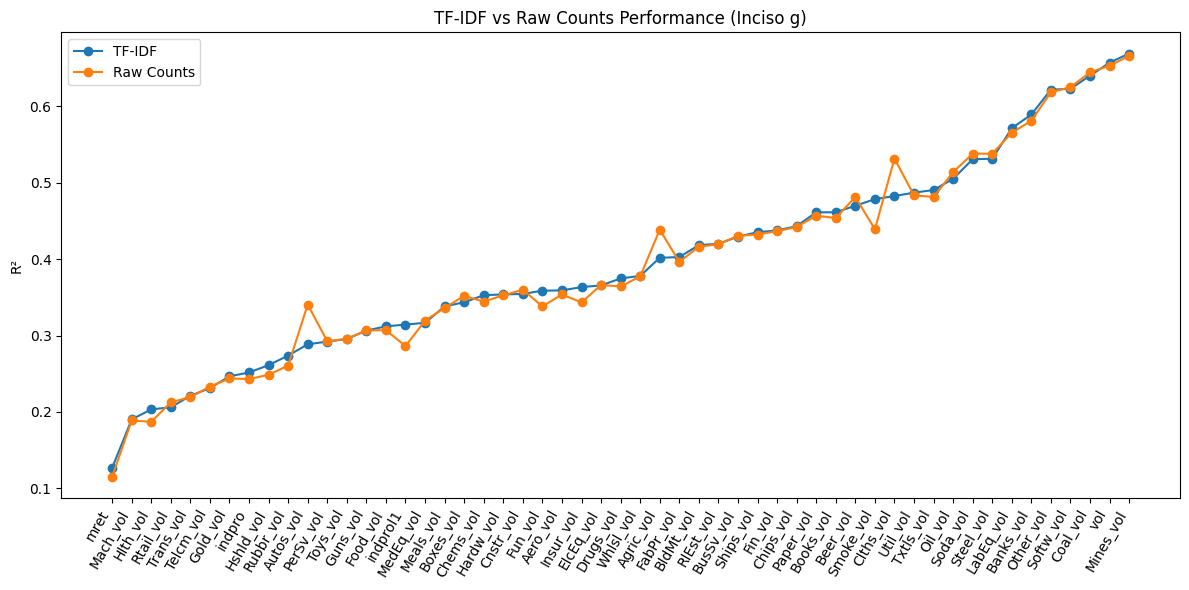

In [251]:
df_plot = df_vect_tfidf_information.sort_values("rsquared_tfidf")

plt.figure(figsize=(12,6))

plt.plot(
    df_plot["variable"],
    df_plot["rsquared_tfidf"],
    marker="o",
    label="TF-IDF"
)

plt.plot(
    df_plot["variable"],
    df_plot["r_squared_vect"],
    marker="o",
    label="Raw Counts"
)

plt.xticks(rotation=60, ha="right")
plt.ylabel("R²")
plt.title("TF-IDF vs Raw Counts Performance (Inciso g)")
plt.legend()

plt.tight_layout()
plt.show()

Converting raw counts into TF-IDF does not materially change the explanatory power across most dependent variables. The two approaches yield very similar R² values. This suggests that after filtering very common and very rare terms, the predictive content is not driven by overly frequent words. TF-IDF slightly re-weights terms but does not dramatically improve performance relative to raw counts.